<b>Изучим социально-демографические признаки подписчиц следующих групп: </b>

1. Themiscyra
2. self love is the best love.
3. гад блесс вимен
4. FemVisually

Все они - феминистской направленности, поэтому предположим, что обобщенная аудитория этих пабликов - девушки 14-25 лет, преимущественно из достаточно больших городов (Москва, Петербург, Казань и тд) с высшим или средним специальным образованием.

In [113]:
# импорт библиотек
import datetime                  
import pickle                    
import requests                  
import pandas as pd              
import numpy as np               
import time            
from tqdm import tqdm_notebook 

In [91]:
# версия API
version = '5.103' 
# токен из файла
with open('token.txt') as f:
    token = f.read()

Определяем функции, которые:
1. Вернут список всех пользовательниц данной группы

In [92]:
def getGroupMembers(group_id):
    
    # число запросов, к-ое надо сделать
    count = vkDownload('groups.getMembers','group_id=' + group_id)['response']['count']
    
    # число запросов, к-ое понадобится
    n = int(np.ceil(count/1000))  
    
    # список для id пользовательниц
    members = []     
    
    for i in tqdm_notebook(range(n)): 
        
        # получение пользовательниц группы
        current_members = vkDownload('groups.getMembers','group_id='+group_id+'&offset='+str(1000*i))
        members.extend(current_members['response']['items'])
        
        # ожидание перед следующим реквестом
        time.sleep(0.4)
        
    return members

2. Вернут результат запроса по методу

In [93]:
def vkDownload(method, parameters, token=token, version=version):
    
    # ссылка
    url = 'https://api.vk.com/method/{method}?{parameters}&access_token={token}&v={version}'
    url = url.format(method=method, parameters=parameters, token=token, version=version)
    
    # запрос ссылки и перевод в словарь
    response = requests.get(url).json()
    
    return response

3. Вернут словарь с выгруженными социально-демографическими данными по всем пользовательницам, подписанным на группы

In [103]:
def getUserInformation():
    
    # пустой словарь для пользовательниц и их характеристик
    groups_followers_info = {}
    
    # цикл для обработки каждой пользовательницы каждой группы
    for group, followers in groups_followers.items():
        current_info = []
        count = len(followers)
        
        # уточнение числап запросов
        n = int(np.ceil(count/500))
        
        #цикл для обработки и записи актуального среза пользовательниц
        for i in tqdm_notebook(range(n)):
            ids = followers[i*500:(i+1)*500]
            ids = ','.join([str(user) for user in ids])
            info = vkDownload('users.get','user_ids={}&fields={}'.format(ids, fields))
            info = info['response']
            current_info.extend(info)
            time.sleep(0.4)
        
        # запись данных в словарь
        groups_followers_info[group] = current_info
    
    return groups_followers_info

<b>Соберем социально-демографические характеристики подписчиц</b>:

Задаем необходимые для анализа параметры и указываем словарь с названиями и id групп.

In [96]:
fields = 'bdate, city, home_town, sex, education'
fem_groups = {
     'Themiscyra' : 'themiscyra',
     'self love is the best love.' : 'selfloveisthebestlove',
     'гад блесс вимен' : 'cateisyourgoddes',
     'FemVisually' : 'femvisually',
    }


С помощью цикла скачиваем id всех подписчиц в словарь "groups_followers", где ключ — название группы, значение — список айди.

In [97]:
groups_followers = {}
for group, group_id in fem_groups.items():
    groups_followers[group] = getGroupMembers(group_id)

C:\Users\риночка\AppData\Local\Temp\ipykernel_30536\576699912.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

In [98]:
# сохранение словаря
with open('groups_followers', 'wb') as f:
    pickle.dump(groups_followers, f)

Выводим количество подписчиц в каждой группе и количество уникальных подписчиц.

In [114]:
for group, followers in groups_followers.items():
    print('В фем-группе "{}" {} подписчиц'.format(group, len(followers)))
print(f'\nУникальных подписчиц: {len(list(set(sum(groups_followers.values(), []))))}')

В фем-группе "Themiscyra" 44295 подписчиц
В фем-группе "self love is the best love." 52170 подписчиц
В фем-группе "гад блесс вимен" 11480 подписчиц
В фем-группе "FemVisually" 160692 подписчиц

Уникальных подписчиц: 242280


Далее необходимо получить информацию по каждой из подписчиц.

In [104]:
groups_followers_info = getUserInformation()

C:\Users\риночка\AppData\Local\Temp\ipykernel_30536\1277747488.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

In [158]:
# датафрейм
groups_followers_info_df = pd.DataFrame()

# цикл для превращения словаря в датафрейм
for group, followers in groups_followers_info.items():
    df = pd.DataFrame(followers)
    df['city'] = df.city.apply(lambda x: x['title'] if x is not np.nan else np.nan)
    df['group'] = group
    groups_followers_info_df = pd.concat([groups_followers_info_df, df], axis=0)

In [159]:
# сохранение результата
with open('groups_followers_info', 'wb') as f:
     pickle.dump(groups_followers_info, f)

In [160]:
# удаление неактивных (удаленных) аккаунтов
groups_followers_info_df = groups_followers_info_df.drop(groups_followers_info_df[groups_followers_info_df['deactivated'] == 'deleted'].index)

In [161]:
groups_followers_info_df

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,university,university_name,faculty,faculty_name,graduation,education_form,education_status,home_town,deactivated,group
0,5037,28.10.1987,Saint Petersburg,1,Anush,Panina,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Themiscyra
1,8485,12.9.1997,Rybnoe,2,Anatoly,Kanevsky,True,False,771.0,РГУ им. С. А. Есенина (РГПУ),206437.0,Факультет истории и международных отношений,2023.0,Distance Learning,Alumnus (Bachelor's),Москва,NaN,Themiscyra
2,10770,NaN,NaN,1,Anna,Serebryannaya,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Themiscyra
3,21034,19.2,Moscow,1,Anastasia,Kuznetsova,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Themiscyra
4,24433,12.2,Saint Petersburg,1,Rinni,Valentayn,True,False,57.0,СПбГТИ (ТУ),799508.0,Экономики и менеджмента,2013.0,Part-time,Alumna (Specialist),Санкт-Петербург,NaN,Themiscyra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160687,1037777902,8.2.1998,NaN,2,Logan,Hawlett,True,False,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually
160688,1037781414,26.10.2002,NaN,2,Thang,Haokip,True,False,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually
160689,1037798940,29.12.2005,NaN,2,Arman,Kha,True,False,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually
160690,1037840332,4.9.1979,NaN,2,อาทิต,คงดี,True,False,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually


In [162]:
# сохранение полученных данных
groups_followers_info_df.to_csv('group-followers.csv', sep=',')

<b>Проанализируем полученные данные: </b>

1. EDA
2. Группировки
3. Среднее и медиана
4. Визуализация

In [163]:
df = groups_followers_info_df

In [164]:
df

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,university,university_name,faculty,faculty_name,graduation,education_form,education_status,home_town,deactivated,group
0,5037,28.10.1987,Saint Petersburg,1,Anush,Panina,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Themiscyra
1,8485,12.9.1997,Rybnoe,2,Anatoly,Kanevsky,True,False,771.0,РГУ им. С. А. Есенина (РГПУ),206437.0,Факультет истории и международных отношений,2023.0,Distance Learning,Alumnus (Bachelor's),Москва,NaN,Themiscyra
2,10770,NaN,NaN,1,Anna,Serebryannaya,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Themiscyra
3,21034,19.2,Moscow,1,Anastasia,Kuznetsova,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Themiscyra
4,24433,12.2,Saint Petersburg,1,Rinni,Valentayn,True,False,57.0,СПбГТИ (ТУ),799508.0,Экономики и менеджмента,2013.0,Part-time,Alumna (Specialist),Санкт-Петербург,NaN,Themiscyra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160687,1037777902,8.2.1998,NaN,2,Logan,Hawlett,True,False,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually
160688,1037781414,26.10.2002,NaN,2,Thang,Haokip,True,False,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually
160689,1037798940,29.12.2005,NaN,2,Arman,Kha,True,False,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually
160690,1037840332,4.9.1979,NaN,2,อาทิต,คงดี,True,False,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually


Отформатируем данные для более удобного анализа.

In [165]:
df['sex'] = df['sex'].apply(lambda x: 'Female' if x == 1 else 'Male')

In [166]:
df['can_access_closed'] = df['can_access_closed'].apply(lambda x: 1 if x == True else 0)

In [167]:
df['is_closed'] = df['is_closed'].apply(lambda x: 1 if x == True else 0)

In [168]:
# создание колонки с возрастом по дате рождения
df_bdate=df['bdate'].str.split('.', expand=True)
df_bdate=df_bdate.rename(columns={0: 'day_bdate', 1: 'month_bdate', 2: 'year_bdate'})
df_bdate['age']=df_bdate['year_bdate'].apply(lambda x: 2025-int(x) if str(x).isdigit() else 0)
df=pd.concat([df, df_bdate['age']], axis=1)
df

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,university,university_name,faculty,faculty_name,graduation,education_form,education_status,home_town,deactivated,group,age
0,5037,28.10.1987,Saint Petersburg,Female,Anush,Panina,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Themiscyra,38
1,8485,12.9.1997,Rybnoe,Male,Anatoly,Kanevsky,1,0,771.0,РГУ им. С. А. Есенина (РГПУ),206437.0,Факультет истории и международных отношений,2023.0,Distance Learning,Alumnus (Bachelor's),Москва,NaN,Themiscyra,28
2,10770,NaN,NaN,Female,Anna,Serebryannaya,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Themiscyra,0
3,21034,19.2,Moscow,Female,Anastasia,Kuznetsova,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Themiscyra,0
4,24433,12.2,Saint Petersburg,Female,Rinni,Valentayn,1,0,57.0,СПбГТИ (ТУ),799508.0,Экономики и менеджмента,2013.0,Part-time,Alumna (Specialist),Санкт-Петербург,NaN,Themiscyra,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160687,1037777902,8.2.1998,NaN,Male,Logan,Hawlett,1,0,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually,27
160688,1037781414,26.10.2002,NaN,Male,Thang,Haokip,1,0,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually,23
160689,1037798940,29.12.2005,NaN,Male,Arman,Kha,1,0,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually,20
160690,1037840332,4.9.1979,NaN,Male,อาทิต,คงดี,1,0,0.0,,0.0,,0.0,NaN,NaN,,NaN,FemVisually,46


In [174]:
# средний возраст по группам
df[df['age']!=0].groupby(
    by=['group'])[['age']].mean().sort_values(by='age', ascending=False)

,age
group,
гад блесс вимен,30.938879
Themiscyra,30.740605
FemVisually,30.583661
self love is the best love.,28.978191


In [204]:
# общее количество подписчиц обоих полов
df['sex'].value_counts().sort_values(ascending=False).to_frame()

,count
sex,
Female,204220
Male,30827


In [200]:
# средний возраст по полу
df[df['age']!=0].groupby(
    by=['sex'])[['age']].mean().sort_values(by='age', ascending=False)

,age
sex,
Male,34.576935
Female,29.562440


In [205]:
# сооотношение количества подписчиц обоих полов в группах
df.groupby(['group', 'sex']).size().unstack()

sex,Female,Male
group,,
FemVisually,128115,20941
Themiscyra,30998,4113
self love is the best love.,36504,4760
гад блесс вимен,8603,1013


In [220]:
df['city'].value_counts().to_frame()

,count
city,
Moscow,21208
Saint Petersburg,13897
Yekaterinburg,2665
Novosibirsk,2296
Krasnodar,2240
...,...
Owo,1
Snyatin,1
Verkhnie Kigi,1


In [214]:
df.groupby('university_name')['id'].nunique().to_frame().sort_values(by='university_name', ascending=False)

,id
university_name,
한양대학교 (Hanyang University),2
한국학중앙연구원 (Academy of Korean Studies),1
한국폴리텍대학 II (Korea Polytechnics II),1
한국예술종합학교 (Korea National University of Arts),1
한국방송통신대학교 (Korea National Open University),1
...,...
ADPU (Şəki filialı),1
ADMİU (АГУКИ),1
北海道文教大学 (Hokkaido Bunkyo University),1


In [219]:
df[df['age']!=0]['age'].value_counts().to_frame()

,count
age,
25,10193
23,9893
22,9603
24,8933
21,8403
...,...
91,18
89,17
94,15


<b>Результаты:</b>

1. Женщины составляют подавляющее большинство подписчиц во всех группах. Например, в "FemVisually" их 128 тыс. против 20 тыс. мужчин. Общее соотношение: 204 тыс. женщин против 30 тыс. мужчин. Это подтверждает ориентацию сообществ на женщин и их интересы. Однако среди молодежи популярно ставить мужской пол в настройках, даже если они являются женщинами.

2. Основная возрастная группа — 20–30 лет (пик в 25 лет — 10 тыс. человек). После 30 лет количество подписчиц резко снижается. Удивляет наличие небольшого числа пожилых (например, 91 год — 18 человек), но это может быть из-за того, что в ВК указывают очень ранний год рождения (например, 1900).

3. Аудитория по очевидным причинам сконцентрирована в крупных городах России. Москва (21 тыс.) и Санкт-Петербург (14 тыс.) лидируют с большим отрывом, далее идут Екатеринбург (2.6 тыс.) и Новосибирск (2.3 тыс.). Всего представлено 4835 населенных пунктов, включая экзотические (например, "Secret Town"), но большинство имеет всего 1 подписчицу.

<b>Визуализируем некоторые результаты и топы по столбцам:</b>

In [221]:
import matplotlib.pyplot as plt

Топ 10 городов, из которых чаще бывают подписчицы

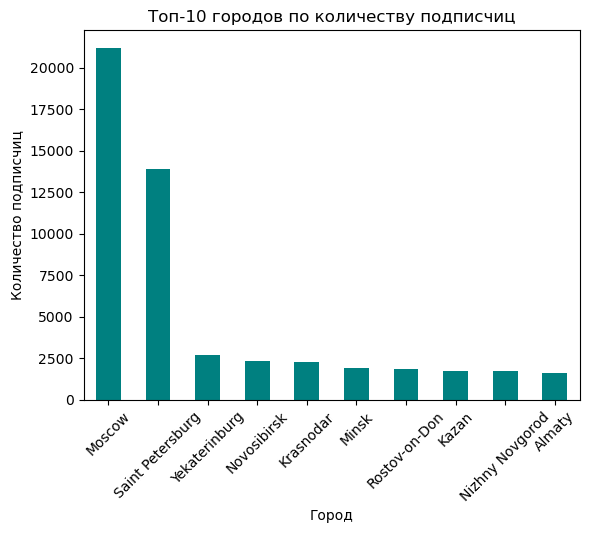

In [242]:
df['city'].value_counts().head(10).plot(kind='bar', color='teal')
plt.title('Топ-10 городов по количеству подписчиц')
plt.xlabel('Город')
plt.ylabel('Количество подписчиц')
plt.xticks(rotation=45)
plt.show()

Распределение полов по полу подписчиц.

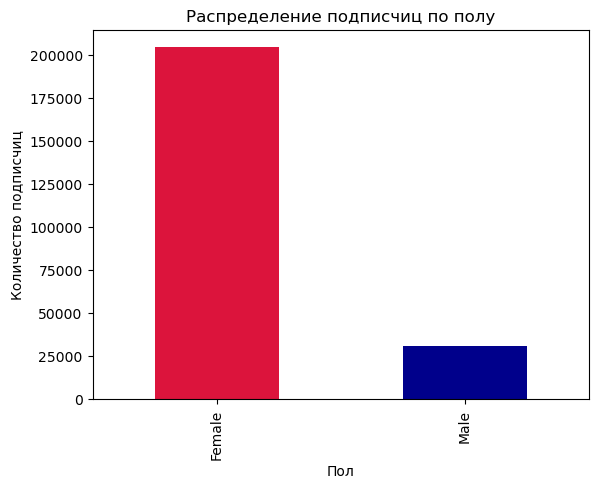

In [243]:
df['sex'].value_counts().plot(kind='bar', color=['crimson', 'darkblue'])
plt.title('Распределение подписчиц по полу')
plt.xlabel('Пол')
plt.ylabel('Количество подписчиц')
plt.show()

Топ-5 университетов по количеству учащихся подписчиц.

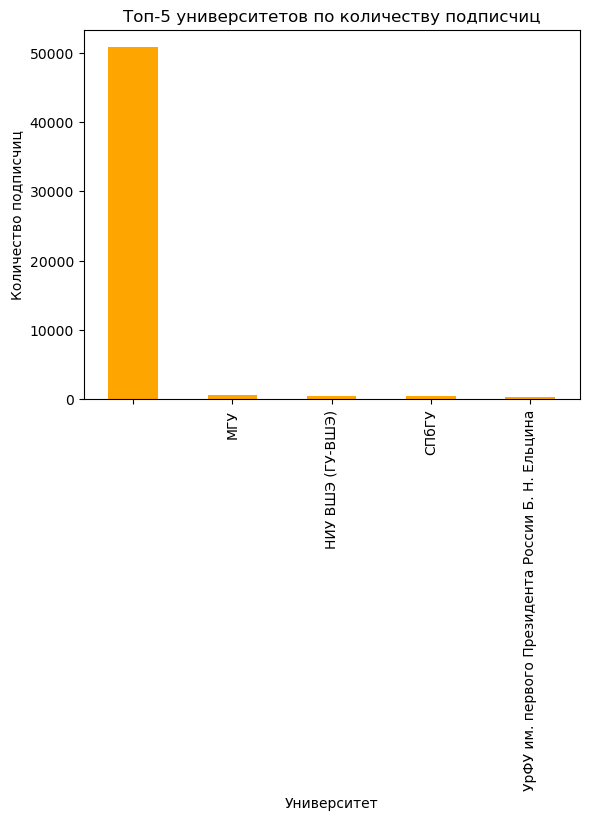

In [246]:
df['university_name'].value_counts().head(5).plot(kind='bar', color='orange')
plt.title('Топ-5 университетов по количеству подписчиц')
plt.xlabel('Университет')
plt.ylabel('Количество подписчиц')
plt.xticks(rotation=90)
plt.show()

Распределение подписчиц по возрасту. За верхнюю границу считаем примерно 60 лет, так как часто в ВК указывают очень ранний год рождения (например, 1900).

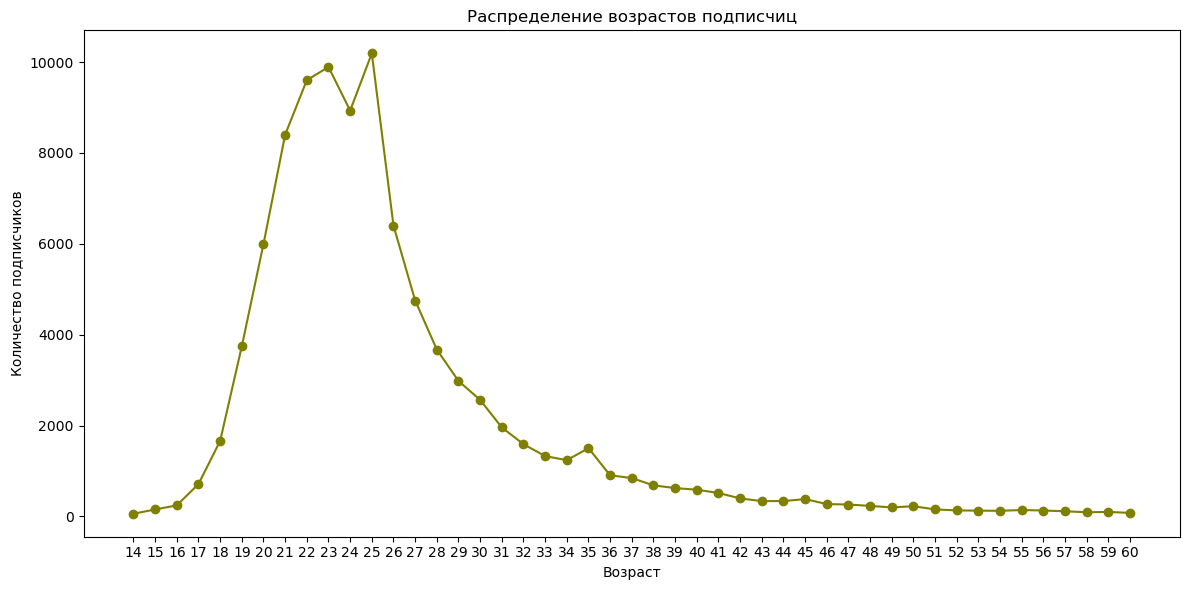

In [270]:
# фильтр данных
valid_ages = df[(df['age'] <= 60) & (df['age'] != 0)]['age']
age_distribution = valid_ages.value_counts().sort_index()

# график
plt.figure(figsize=(12, 6))
plt.plot(age_distribution.index, age_distribution.values, 
         marker='o', linestyle='-', color='olive')

plt.title('Распределение возрастов подписчиц')
plt.xlabel('Возраст')
plt.ylabel('Количество подписчиков')
plt.xticks(range(int(valid_ages.min()), int(valid_ages.max())+1))
plt.tight_layout()
plt.show()

<b>Выводы</b>
1. Гендерный анализ:
Действительно, во всех группах явный перевес женской аудитории. Например, в "FemVisually" женщины составляют 86% подписчиц (128 тыс. и 20 тыс. мужчин), а в "Themiscyra" — 88% (31 тыс. и 4 тыс.). Это подчеркивает гендерную направленность сообществ на женскую аудиторию, что соответствует их тематике (феминизм, саморазвитие, поддержка женщин). Также, как было сказано, женщины иногда указывают мужской пол, даже если это не соответствует действительности.

2. Возрастной анализ:
Средний возраст подписчиц колеблется в узком диапазоне 25-31 год, что указывает на целевую аудиторию — молодые женщины. Группа "рад блесс вимен" имеет самую старшую аудиторию (30.9 лет), тогда "self love is the best love." — самую младшую (28.9 лет). Однако тогда наша теория о том, что ЦА таких сообществ — молодые девушки 14-25 лет, не подтверждается: в этих группах сидят более взрослые женщины. Неожиданно наличие пожилых подписчиков (80+ лет), хоть и в минимальных количествах (10–18 человек). Это может быть связано с, как уже было сказано, намеренными или случайными ошибками в годе рождения. Или эта цифра показывает, что некоторые индивидуумы из старшего поколения интересуются подобными темами.

3. Географический анализ:
Данные показывают типичную для российских онлайн-сообществ концентрацию аудитории в городах-миллионниках. Москва и Санкт-Петербург вместе составляют 35 тыс. подписчиков (около 60% от видимых данных), что отражает их высокую интернет-активность. Другие города с миллионным населением (Екатеринбург, Новосибирск, Краснодар) представлены в меньшем числе (2-2.6 тыс.), но стабильно.

4. Образовательный анализ
Данные показывают, что наибольшая часть подписчиц либо не имеет образования, либо предпочитает его не указывать. Также большое количество университетов, в которых всего по одной подписчице. Это может быть, например, намеренной ошибкой. Поэтому наша теория, что подписчицы обычно имеют образование, опровергается, однако с оговоркой, что также возможны намеренные или случайные ошибки.